# MLP using Keras & Scikit-Optimize: Sonar Datasets


Hyper-parameter turning __[Scikit-Optimize](https://scikit-optimize.github.io/index.html)__.


In [4]:
import keras
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
## Importing required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline
import seaborn as sns
import pandas as pd
df = pd.read_csv('sonar.csv', header=None)
X_test = df.sample(frac=0.20, replace=True, random_state=1)
Y_test = X_test[60]
X_test.drop([60],axis=1, inplace=True)
X_test.head()
X_train = df.drop(X_test.index)
Y_train = X_train[60]
X_train.drop([60],axis=1, inplace=True)
X_train.head()
#X_test.head()


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0104,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062


In [5]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
print("X_test shape: ",X_test.shape)
print("X_train shape: ",X_train.shape)

X_test shape:  (42, 60)
X_train shape:  (168, 60)


Text(0.5, 1.0, 'Density Plot for Sonar Features in Training Dataset')

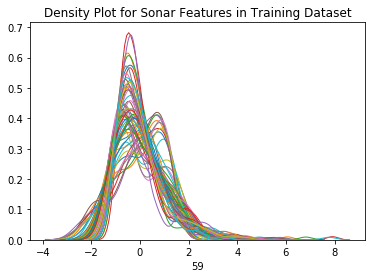

In [6]:
# Iterate through the features
for i in X_train.columns:
    # Draw the density plot
    sns.distplot(X_train[i], hist = False, kde = True,
                 kde_kws = {'linewidth': 1})
    
plt.title('Density Plot for Sonar Features in Training Dataset')

Text(0.5, 1.0, 'Density Plot for Sonar Features in Test Dataset')

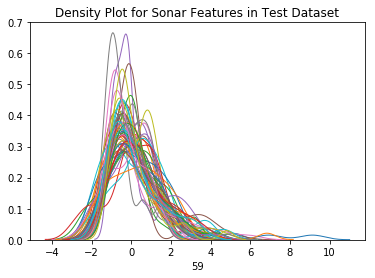

In [7]:
# Iterate through the features
for i in X_test.columns:
    # Draw the density plot
    sns.distplot(X_test[i], hist = False, kde = True,
                 kde_kws = {'linewidth': 1})
    
plt.title('Density Plot for Sonar Features in Test Dataset')

Plot some sample images along with their labels.

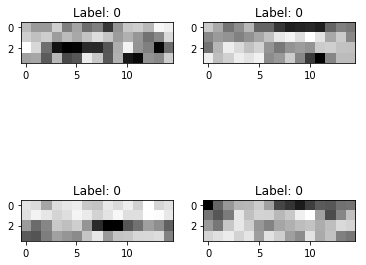

In [8]:
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%Y_train.iloc[i])
    plt.imshow(X_train.iloc[i].values.reshape(4,15),cmap='Greys');

In [9]:
## Changing labels to one-hot encoded vector
lb = LabelBinarizer()
y_train_one_hot = lb.fit_transform(Y_train)
y_test_one_hot = lb.transform(Y_test)
print('Train labels dimension:');print(y_train_one_hot.shape)
print('Test labels dimension:');print(y_test_one_hot.shape)

Train labels dimension:
(168, 1)
Test labels dimension:
(42, 1)


Now we have processed the data, let's start building our multi-layer perceptron using tensorflow. We will begin by importing the required libraries.

In [10]:
## Importing required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

### Define & Compile Keras Model for Hyper-Parameter Optimization


In [11]:
# Defining various initialization parameters for MLP model
num_features = X_train.shape[1]; num_classes = y_train_one_hot.shape[1] 

# Let's create a helper function first which builds the model with various parameters.
def get_model(dense_0_neurons, dense_1_neurons, dropout_rate, input_dim, num_classes):
    # Builds a Sequential MLP model using Keras and returns it
    
    # Define the keras model
    model = Sequential()
    model.add(Dense(dense_0_neurons, input_dim=input_dim, activation='relu', name="dense_1"))
    model.add(Dense(dense_1_neurons, activation='relu', name="dense_2"))
    model.add(Dropout(dropout_rate, name="dropout"))
    model.add(Dense(num_classes, activation='sigmoid', name="dense_3"))
    return model

### Setup Keras Model for Scikit-Optimizer

In [12]:
import skopt
from skopt import gp_minimize

# Specify `Static' Parameters
STATIC_PARAMS = {num_features, num_classes}

# Bounded region of parameter space
# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the dropout_rate)
SPACE = [skopt.space.Integer(8, 512, name='dense_0_neurons'),
         skopt.space.Integer(16, 512, name='dense_1_neurons'),
        skopt.space.Real(0.0, 0.6, name='dropout_rate')]

# This decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters         
@skopt.utils.use_named_args(SPACE)
         
# Define objective for optimization
def objective(**params):
  
    # All parameters: 
    #all_params = {**params, **STATIC_PARAMS}
    
    # Create the model using a specified hyperparameters.
    #model = get_model(all_params)
    model = get_model(params["dense_0_neurons"], params["dense_1_neurons"], params["dropout_rate"], num_features, num_classes)

    # Compile the keras model for a specified number of epochs.
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Fit keras model
    history = model.fit(X_train, y_train_one_hot, epochs=1, batch_size=8, 
                        validation_split = 0.20, verbose=1)

    # Evaluate the model with the eval dataset.
    score = model.evaluate(X_test, y_test_one_hot,
                                  batch_size=8, verbose=1)
    print('Test loss:', score[0], '   Test accuracy:', score[1])

    # Return the accuracy.
    return -1.0 * score[1]

### Run Scikit-Optimizer
There are several methods for optimization: https://scikit-optimize.github.io/modules/minimize_functions.html#minimize-functions

In [13]:
import warnings
warnings.filterwarnings('ignore')

results_gp = skopt.gbrt_minimize(objective,     # the function to minimize
                          SPACE,              # the bounds on each dimension of x
                          x0=[100,50,0],      # the starting point
                          acq_func="LCB",     # the acquisition function (optional)
                          n_calls=50,         # the number of evaluations of f including at x0
                          n_random_starts=4,  # the number of random initialization points
                          random_state=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 143us/step
Test loss: 0.534608869325547    Test accuracy: 0.6904761904761905
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 163us/step
Test loss: 0.5433516956510998    Test accuracy: 0.7619047619047619
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 156us/step
Test loss: 0.46201860904693604    Test accuracy: 0.7857142857142857
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 151us/step
Test loss: 0.6245636684553963    Test accuracy: 0.6666666666666666
Train on 134 samples, validate on 34 samples
Epoch 1/1
42

42/42 [==============================] - 0s 187us/step
Test loss: 0.49549870831625803    Test accuracy: 0.7857142857142857
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 165us/step
Test loss: 0.5347437404450917    Test accuracy: 0.7857142857142857
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 259us/step
Test loss: 0.6621633200418382    Test accuracy: 0.5714285714285714
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 170us/step
Test loss: 0.4921756415140061    Test accuracy: 0.7380952380952381
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 201us/step
Test loss: 0.6755046220052809    Test accuracy: 0.6190476190476191
Train on 134 samples, validate on 34 samples
Epoch 1/1
42/42 [==============================] - 0s 198us/step
Test loss: 0.5753810065133231    Test accuracy: 0.761904761

#### Get Best Parameter Set

In [14]:
print("Best score=%.4f" % results_gp.fun)

print("""Best parameters:
- dense_0_neurons=%d
- dense_1_neurons=%d
- dropout_rate=%.6f""" % 
      (results_gp.x[0], results_gp.x[1],
                            results_gp.x[2]))

Best score=-0.8333
Best parameters:
- dense_0_neurons=493
- dense_1_neurons=435
- dropout_rate=0.315912


#### Convergence Plot

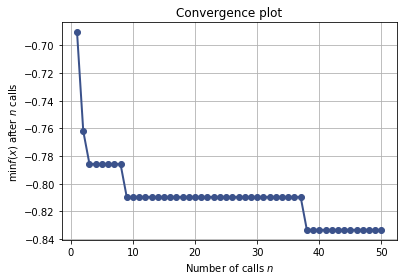

In [15]:
from skopt.plots import plot_convergence
plot_convergence(results_gp)

#### Evaluations Plot
plots.plot_evaluations creates a grid of size n_dims by n_dims. The diagonal shows histograms for each of the dimensions. In the lower triangle (just one plot in this case) a two dimensional scatter plot of all points is shown. The order in which points were evaluated is encoded in the color of each point. Darker/purple colors correspond to earlier samples and lighter/yellow colors correspond to later samples. A red point shows the location of the minimum found by the optimization process.

You should be able to see that points start clustering around the location of the true miminum. The histograms show that the objective is evaluated more often at locations near to one of the three minima.

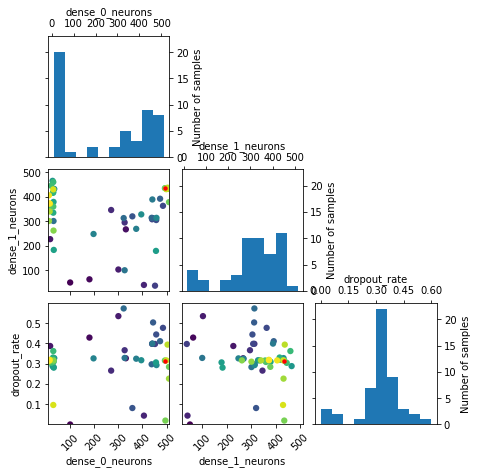

In [16]:
from skopt.plots import plot_evaluations
_ = plot_evaluations(results_gp, bins=10)

#### Objective Partial Dependence Plots
Partial dependence plots were proposed by [Friedman (2001)] as a method for interpreting the importance of input features used in gradient boosting machines. The idea is to visualize how the value of $i$-th variable $x_i$ influences the function $f$ after averaging out the influence of all other variables.For more details see: https://christophm.github.io/interpretable-ml-book/pdp.html

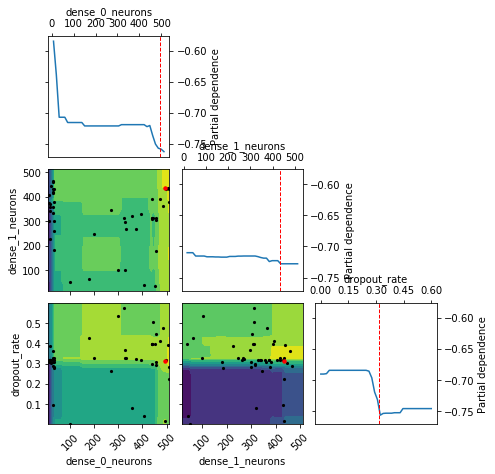

In [17]:
from skopt.plots import plot_objective
_ = plot_objective(results_gp)

### Learn Further using Best Hyper-parameter Settings

In [18]:
# Create the model using a specified hyperparameters.

# Get best hyper-parameters
dense_0_neurons=results_gp.x[0]; dense_1_neurons=results_gp.x[1]; dropout_rate=results_gp.x[2]

# Build 
model = get_model(dense_0_neurons, dense_1_neurons, dropout_rate, num_features, num_classes)

# Compile the keras model for a specified number of epochs.
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fit keras model
history = model.fit(X_train, y_train_one_hot, epochs=16, batch_size=8, 
                        validation_split = 0.20, verbose=1)

# Evaluate the model with the eval dataset.
score = model.evaluate(X_test, y_test_one_hot,
                                  batch_size=8, verbose=1)
print('Test loss:', score[0], '   Test accuracy:', score[1])

Train on 134 samples, validate on 34 samples
Epoch 1/16
134/134 [==============================] - 3s 21ms/step - loss: 0.6017 - acc: 0.6791 - val_loss: 1.3082 - val_acc: 0.3235
Epoch 2/16
134/134 [==============================] - 0s 653us/step - loss: 0.2552 - acc: 0.9104 - val_loss: 1.0871 - val_acc: 0.4706
Epoch 3/16
134/134 [==============================] - 0s 781us/step - loss: 0.1721 - acc: 0.9627 - val_loss: 1.0112 - val_acc: 0.4706
Epoch 4/16
134/134 [==============================] - 0s 718us/step - loss: 0.0852 - acc: 0.9925 - val_loss: 0.8551 - val_acc: 0.5588
Epoch 5/16
134/134 [==============================] - 0s 753us/step - loss: 0.0585 - acc: 1.0000 - val_loss: 1.2511 - val_acc: 0.4706
Epoch 6/16
134/134 [==============================] - 0s 974us/step - loss: 0.0225 - acc: 1.0000 - val_loss: 0.8918 - val_acc: 0.5882
Epoch 7/16
134/134 [==============================] - 0s 813us/step - loss: 0.0158 - acc: 1.0000 - val_loss: 1.0708 - val_acc: 0.5882
Epoch 8/16
134/134

### Check Training History
In this section, we will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting. Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [19]:
# Define function for plotting history
import matplotlib.pyplot as plt
def plot_metrics(history):
  metrics =  ['loss', 'acc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.tight_layout()
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

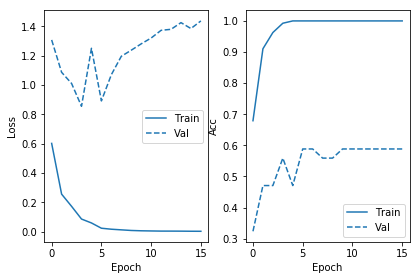

In [20]:
# Plot the training/validation history of our Keras model
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(history)

### Evaluate Metrics
You can use a confusion matrix to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [21]:
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion Matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

Evaluate your model on the test dataset and display the evaluation metrics and the confusion matrix.

loss :  0.5077158559662556
acc :  0.8809523809523809



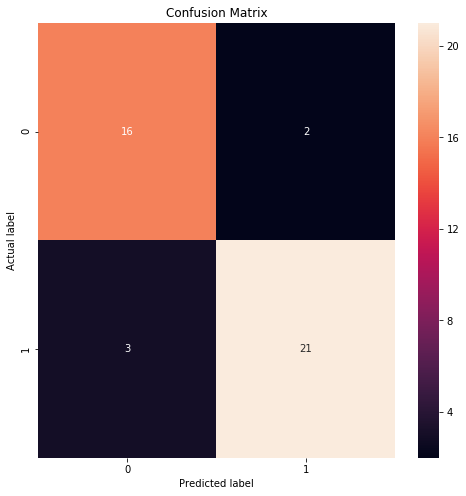

In [22]:
y_test_predictions = model.predict_classes(X_test, batch_size=8)
baseline_results = model.evaluate(X_test, y_test_one_hot,
                                  batch_size=8, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(Y_test, y_test_predictions)

### Conclusion
As we can see we have successfully trained a Multi-Layer perceptron which was written in Keras using TensorFlow backend with high validation accuracy!